# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning 

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

Since we're trying to predict a number, this kind of problem is known as a **regression problem**.

The data and evaluation metric we'll be using (root mean square log error or RMSLE) is from the [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview).

The techniques used in here have been inspired and adapted from [the fast.ai machine learning course](https://course18.fast.ai/ml).

## What we'll end up with

Since we already have a dataset, we'll approach the problem with the following machine learning modelling framework.

| <img src="../images/ml101-6-step-ml-framework.png" width=500/> | 
|:--:| 
| 6 Step Machine Learning Modelling Framework ([read more](https://whimsical.com/9g65jgoRYTxMXxDosndYTB)) |

To work through these topics, we'll use pandas, Matplotlib and NumPy for data anaylsis, as well as, Scikit-Learn for machine learning and modelling tasks.

| <img src="../images/supervised-projects-6-step-ml-framework-tools-highlight.png" width=500/> | 
|:--:| 
| Tools which can be used for each step of the machine learning modelling process. |

We'll work through each step and by the end of the notebook, we'll have a trained machine learning model which predicts the sale price of a bulldozer given different characteristics about it.

## 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) or view it on Google Sheets.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

### Importing the data and preparing it for modelling

In [1]:
# Import data analysis tools 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now we've got our tools for data analysis ready, we can import the data and start to explore it.

For this project, we've [downloaded the data from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data) and stored it under the file path `"../data/"`.

In [2]:
# Import the training and validation set
df = pd.read_csv("../data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [3]:
# No parse_dates... check dtype of "saledate"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

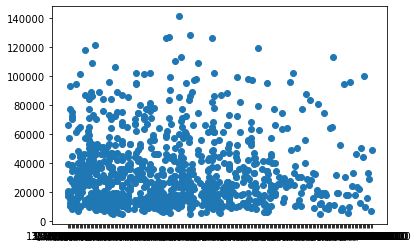

In [4]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

<AxesSubplot:ylabel='Frequency'>

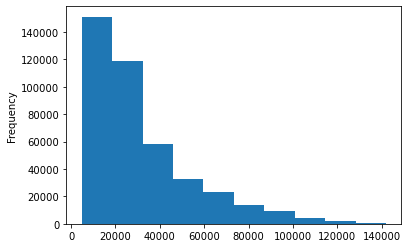

In [5]:
df.SalePrice.plot.hist()

### Parsing dates
When working with time series data, it's a good idea to make sure any date data is the format of a [datetime object](https://docs.python.org/3/library/datetime.html) (a Python data type which encodes specific information about dates).

In [45]:
df_train_valid = pd.read_csv("../data/bluebook-for-bulldozers/TrainAndValid.csv",
                 parse_dates=["saledate"])
df_test = pd.read_csv('../data/bluebook-for-bulldozers/Test.csv', parse_dates=['saledate'])


C:\Users\Asus\anaconda3\envs\DataAnalysisEnv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [46]:
df_train_valid.shape, df_test.shape

((412698, 53), (12457, 52))

In [47]:
df = pd.concat([df_train_valid.drop('SalePrice', axis=1), df_test], axis=0, ignore_index=True)

In [48]:
# With parse_dates... check dtype of "saledate"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425155 entries, 0 to 425154
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   425155 non-null  int64         
 1   MachineID                 425155 non-null  int64         
 2   ModelID                   425155 non-null  int64         
 3   datasource                425155 non-null  int64         
 4   auctioneerID              405019 non-null  float64       
 5   YearMade                  425155 non-null  int64         
 6   MachineHoursCurrentMeter  149633 non-null  float64       
 7   UsageBand                 75504 non-null   object        
 8   saledate                  425155 non-null  datetime64[ns]
 9   fiModelDesc               425155 non-null  object        
 10  fiBaseModel               425155 non-null  object        
 11  fiSecondaryDesc           280453 non-null  object        
 12  fi

In [49]:
df.shape

(425155, 52)

In [50]:
len(df.index.unique()), len(df.index)

(425155, 425155)

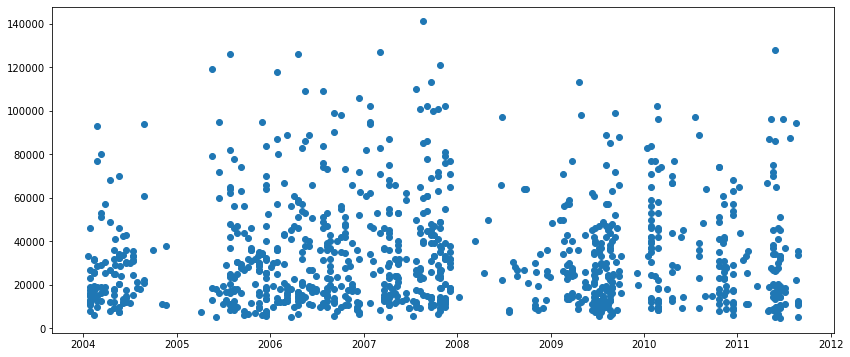

In [52]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(df["saledate"][:1000], df_train_valid["SalePrice"][:1000])

In [53]:
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00
fiModelDesc,521D,950FII,226,PC120-6E,S175


In [56]:
df.saledate.tail(20)

425135   2012-10-24
425136   2012-10-25
425137   2012-08-22
425138   2012-10-27
425139   2012-09-27
425140   2012-10-11
425141   2012-10-11
425142   2012-08-16
425143   2012-11-01
425144   2012-10-27
425145   2012-10-13
425146   2012-10-27
425147   2012-10-24
425148   2012-10-24
425149   2012-10-24
425150   2012-10-24
425151   2012-10-24
425152   2012-10-24
425153   2012-10-24
425154   2012-09-19
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

As we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.

In [57]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
76171    1989-01-31
169757   1989-01-31
115892   1989-01-31
98567    1989-01-31
127000   1989-01-31
28820    1989-01-31
101796   1989-01-31
75832    1989-01-31
55455    1989-01-31
92256    1989-01-31
115957   1989-01-31
92294    1989-01-31
92301    1989-01-31
55454    1989-01-31
127132   1989-01-31
81383    1989-01-31
142491   1989-01-31
54181    1989-01-31
28603    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

Since we're going to be manipulating the data, we'll make a copy of the original DataFrame and perform our changes there.

This will keep the original DataFrame in tact if we need it again.

In [58]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

### Add datetime parameters for saledate column

Why?

So we can enrich our dataset with as much information as possible.

Because we imported the data using `read_csv()` and we asked pandas to parse the dates using `parase_dates=["saledate"]`, we can now access the [different datetime attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) of the `saledate` column.

In [59]:
# Add datetime parameters for saledate
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear
df_tmp["saleIsMonthStart"] = df_tmp.saledate.dt.is_month_start
df_tmp["saleIsMonthEnd"] = df_tmp.saledate.dt.is_month_end
df_tmp["saleIsQuarterStart"] = df_tmp.saledate.dt.is_quarter_start
df_tmp["saleIsQuarterEnd"] = df_tmp.saledate.dt.is_quarter_end
df_tmp["saleIsYearStart"] = df_tmp.saledate.dt.is_year_start
df_tmp["saleIsYearEnd"] = df_tmp.saledate.dt.is_year_end

# Drop original saledate
df_tmp.drop("saledate", axis=1, inplace=True)

We could add more of these style of columns, such as, whether it was the start or end of a quarter but these will do for now.

**Challenge:** See what other [datetime attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) you can add to `df_tmp` using a similar technique to what we've used above. Hint: check the bottom of the pandas.DatetimeIndex docs.

In [60]:
df_tmp.head().T

,205615,76171,169757,115892,98567
SalesID,1646770,1364654,1597053,1453054,1415950
MachineID,1126363,1270628,1100960,1117184,1142272
ModelID,8434,7289,8180,3854,3357
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
...,...,...,...,...,...
saleIsMonthEnd,False,True,True,True,True
saleIsQuarterStart,False,False,False,False,False
saleIsQuarterEnd,False,False,False,False,False
saleIsYearStart,False,False,False,False,False


In [61]:
# Check the different values of different columns
df_tmp.state.value_counts()

Florida           68419
Texas             55262
California        30631
Washington        16623
Georgia           15196
Maryland          13874
Mississippi       13483
Ohio              12666
Illinois          12009
Colorado          11800
New Jersey        11404
North Carolina    11047
Tennessee         10711
Pennsylvania      10562
Alabama           10459
South Carolina    10018
Arizona            9737
New York           8866
Connecticut        8501
Minnesota          8008
Missouri           7514
Nevada             7176
Louisiana          6959
Kentucky           5526
Maine              5106
Indiana            4197
Arkansas           4049
New Mexico         3670
Utah               3172
Wisconsin          2889
New Hampshire      2806
Unspecified        2801
Virginia           2507
Idaho              2106
Michigan           2041
Oregon             1976
Wyoming            1736
Montana            1467
Iowa               1441
Oklahoma           1403
West Virginia       936
Nebraska        

## 5. Modelling

We've explored our dataset a little as well as enriched it with some datetime attributes, now let's try to model.

Why model so early?

We know the evaluation metric we're heading towards. We could spend more time doing exploratory data analysis (EDA), finding more out about the data ourselves but what we'll do instead is use a machine learning model to help us do EDA.

Remember, one of the biggest goals of starting any new machine learning project is reducing the time between experiments.

Following the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), we find a [RandomForestRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn-ensemble-randomforestregressor) might be a good candidate.

In [62]:
# This won't work since we've got missing numbers and categories
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

KeyError: "['SalePrice'] not found in axis"

In [63]:
# Check for missing categories and different datatypes
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425155 entries, 205615 to 422501
Data columns (total 62 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   425155 non-null  int64  
 1   MachineID                 425155 non-null  int64  
 2   ModelID                   425155 non-null  int64  
 3   datasource                425155 non-null  int64  
 4   auctioneerID              405019 non-null  float64
 5   YearMade                  425155 non-null  int64  
 6   MachineHoursCurrentMeter  149633 non-null  float64
 7   UsageBand                 75504 non-null   object 
 8   fiModelDesc               425155 non-null  object 
 9   fiBaseModel               425155 non-null  object 
 10  fiSecondaryDesc           280453 non-null  object 
 11  fiModelSeries             60673 non-null   object 
 12  fiModelDescriptor         77840 non-null   object 
 13  ProductSize               202141 non-nu

In [64]:
# Check for missing values
df_tmp.isna().sum().head(20)

SalesID                          0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    275522
UsageBand                   349651
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             144702
fiModelSeries               364482
fiModelDescriptor           347315
ProductSize                 223014
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                315309
Enclosure                      336
dtype: int64

## Convert strings to categories

One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

To do this we can use the [pandas types API](https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality) which allows us to interact and manipulate the types of data.

In [65]:
df_tmp.head().T.head(60)

,205615,76171,169757,115892,98567
SalesID,1646770,1364654,1597053,1453054,1415950
MachineID,1126363,1270628,1100960,1117184,1142272
ModelID,8434,7289,8180,3854,3357
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1968,1979,1977,1978
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,980,510,966C,12G
fiBaseModel,TD20,980,510,966,12


In [66]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [92]:
# These columns contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [93]:
# If you're wondering what df.items() does, let's use a dictionary as an example
random_dict = {"key1": "hello",
               "key2": "world!"}

for key, value in random_dict.items():
    print(f"This is a key: {key}")
    print(f"This is a value: {value}")

This is a key: key1
This is a value: hello
This is a key: key2
This is a value: world!


In [119]:
# This will turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [120]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425155 entries, 0 to 425154
Data columns (total 62 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   425155 non-null  int64   
 1   MachineID                 425155 non-null  int64   
 2   ModelID                   425155 non-null  int64   
 3   datasource                425155 non-null  int64   
 4   auctioneerID              405019 non-null  float64 
 5   YearMade                  425155 non-null  int64   
 6   MachineHoursCurrentMeter  149633 non-null  float64 
 7   UsageBand                 75504 non-null   category
 8   fiModelDesc               425155 non-null  category
 9   fiBaseModel               425155 non-null  category
 10  fiSecondaryDesc           280453 non-null  category
 11  fiModelSeries             60673 non-null   category
 12  fiModelDescriptor         77840 non-null   category
 13  ProductSize               202

In [121]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [122]:
df_tmp.Blade_Type.cat.codes

0         7
1        -1
2        -1
3        -1
4        -1
         ..
425150   -1
425151   -1
425152   -1
425153   -1
425154   -1
Length: 425155, dtype: int8

All of our data is categorical and thus we can now turn the categories into numbers, however it's still missing values...

In [123]:
df_tmp.isnull().sum()/len(df_tmp)

SalesID               0.000000
MachineID             0.000000
ModelID               0.000000
datasource            0.000000
auctioneerID          0.047362
                        ...   
saleIsMonthEnd        0.000000
saleIsQuarterStart    0.000000
saleIsQuarterEnd      0.000000
saleIsYearStart       0.000000
saleIsYearEnd         0.000000
Length: 62, dtype: float64

In the format it's in, it's still good to be worked with, let's save it to file and reimport it so we can continue on.

### Save Processed Data

In [112]:
# Save preprocessed data
df_tmp.to_csv("../data/bluebook-for-bulldozers/train_valid_test_combined_with__all_categorical_columns_having_same_codes.csv",
              index=False)

In [116]:
# Import preprocessed data
df_tmp = pd.read_csv("../data/bluebook-for-bulldozers/train_valid_test_combined_with__all_categorical_columns_having_same_codes.csv")
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1364654,1597053,1453054,1415950
MachineID,1126363,1270628,1100960,1117184,1142272
ModelID,8434,7289,8180,3854,3357
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
...,...,...,...,...,...
saleIsMonthEnd,False,True,True,True,True
saleIsQuarterStart,False,False,False,False,False
saleIsQuarterEnd,False,False,False,False,False
saleIsYearStart,False,False,False,False,False


In [124]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425155 entries, 0 to 425154
Data columns (total 62 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   425155 non-null  int64   
 1   MachineID                 425155 non-null  int64   
 2   ModelID                   425155 non-null  int64   
 3   datasource                425155 non-null  int64   
 4   auctioneerID              405019 non-null  float64 
 5   YearMade                  425155 non-null  int64   
 6   MachineHoursCurrentMeter  149633 non-null  float64 
 7   UsageBand                 75504 non-null   category
 8   fiModelDesc               425155 non-null  category
 9   fiBaseModel               425155 non-null  category
 10  fiSecondaryDesc           280453 non-null  category
 11  fiModelSeries             60673 non-null   category
 12  fiModelDescriptor         77840 non-null   category
 13  ProductSize               202

Excellent, our processed DataFrame has the columns we added to it but it's still missing values.

In [125]:
# Check missing values
df_tmp.isna().sum()

SalesID                   0
MachineID                 0
ModelID                   0
datasource                0
auctioneerID          20136
                      ...  
saleIsMonthEnd            0
saleIsQuarterStart        0
saleIsQuarterEnd          0
saleIsYearStart           0
saleIsYearEnd             0
Length: 62, dtype: int64

## Split Data into train, validation, and test sets

Now that we have encoded the categorical features of the entire dataset uniformly, we will split the data into train, validation, and test sets according to the format soecified in the contest page on Kaggle.

Reason we are splitting the data here, is that we don't want to fill in the missing values based on data from the future. 
The train set is the data from the past.
The validation set is the data that is supposed to represent the future.
And the test set is the data from the future.

If we fill in the missing numerical values, say, with the medians of the respective columns, in the overall dataset, then we will be doing data snooping as those median values will also be impacted by values from the validaiton and test set, which we are not supposed to use while training the model.


In [126]:
df_train = df_tmp[df_tmp['saleYear'] < 2012]
df_valid = df_tmp[(df_tmp['saleYear'] == 2012) & (df_tmp['saleMonth'] < 5)]
df_test = df_tmp[(df_tmp['saleYear'] == 2012) & (df_tmp['saleMonth'] > 4)]

df_train.shape, df_valid.shape, df_test.shape

((401125, 62), (11573, 62), (12457, 62))

In [127]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 0 to 401124
Data columns (total 62 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   401125 non-null  int64   
 1   MachineID                 401125 non-null  int64   
 2   ModelID                   401125 non-null  int64   
 3   datasource                401125 non-null  int64   
 4   auctioneerID              380989 non-null  float64 
 5   YearMade                  401125 non-null  int64   
 6   MachineHoursCurrentMeter  142765 non-null  float64 
 7   UsageBand                 69639 non-null   category
 8   fiModelDesc               401125 non-null  category
 9   fiBaseModel               401125 non-null  category
 10  fiSecondaryDesc           263934 non-null  category
 11  fiModelSeries             56908 non-null   category
 12  fiModelDescriptor         71919 non-null   category
 13  ProductSize               190

## Fill missing values

From our experience with machine learning models. We know two things:
1. All of our data has to be numerical
2. There can't be any missing values

And as we've seen using `df_tmp.isna().sum()` our data still has plenty of missing values.

Let's fill them.

### Filling numerical values first

We're going to fill any column with missing values with the median of that column.

In [128]:
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofyear
saleIsMonthStart
saleIsMonthEnd
saleIsQuarterStart
saleIsQuarterEnd
saleIsYearStart
saleIsYearEnd


In [129]:
# Check for which numeric columns in train set have null values
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
            
# Check for which numeric columns in validation set have null values
for label, content in df_valid.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
            
# Check for which numeric columns in test set have null values
for label, content in df_test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter
MachineHoursCurrentMeter
MachineHoursCurrentMeter


In [130]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 0 to 401124
Data columns (total 62 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   401125 non-null  int64   
 1   MachineID                 401125 non-null  int64   
 2   ModelID                   401125 non-null  int64   
 3   datasource                401125 non-null  int64   
 4   auctioneerID              380989 non-null  float64 
 5   YearMade                  401125 non-null  int64   
 6   MachineHoursCurrentMeter  142765 non-null  float64 
 7   UsageBand                 69639 non-null   category
 8   fiModelDesc               401125 non-null  category
 9   fiBaseModel               401125 non-null  category
 10  fiSecondaryDesc           263934 non-null  category
 11  fiModelSeries             56908 non-null   category
 12  fiModelDescriptor         71919 non-null   category
 13  ProductSize               190

In [131]:
# Fill numeric rows with the median in train set
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data was missing our not
            df_train[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df_train[label] = content.fillna(content.median())
            
# Fill numeric rows with the median in validation set
for label, content in df_valid.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data was missing our not
            df_valid[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df_valid[label] = content.fillna(content.median())
            
# Fill numeric rows with the median in test set
for label, content in df_test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data was missing our not
            df_test[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df_test[label] = content.fillna(content.median())

<ipython-input-131-0c76e4145303>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[label+"_is_missing"] = pd.isnull(content)
<ipython-input-131-0c76e4145303>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[label] = content.fillna(content.median())
<ipython-input-131-0c76e4145303>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Why add a binary column indicating whether the data was missing or not?

We can easily fill all of the missing numeric values in our dataset with the median. However, a numeric value may be missing for a reason. In other words, absence of evidence may be evidence of absence. Adding a binary column which indicates whether the value was missing or not helps to retain this information.

In [134]:
# Check if there's any null values
for label, content in df_test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [135]:
# Check to see how many examples were missing
df_train.auctioneerID_is_missing.value_counts()

False    380989
True      20136
Name: auctioneerID_is_missing, dtype: int64

### Filling and turning categorical variables to numbers

Now we've filled the numeric values, we'll do the same with the categorical values at the same time as turning them into numbers.

In [136]:
# Check columns which *aren't* numeric
for label, content in df_train.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)
        


UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [137]:
# Turn categorical variables into numbers in training set
for label, content in df_train.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_train[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_train[label] = pd.Categorical(content).codes+1  
        
# Turn categorical variables into numbers in validation set
for label, content in df_valid.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_valid[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_valid[label] = pd.Categorical(content).codes+1        
        
# Turn categorical variables into numbers in test set
for label, content in df_test.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_test[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_test[label] = pd.Categorical(content).codes+1        

<ipython-input-137-efa21893bccf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[label+"_is_missing"] = pd.isnull(content)
<ipython-input-137-efa21893bccf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[label] = pd.Categorical(content).codes+1
<ipython-input-137-efa21893bccf>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [140]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12457 entries, 412698 to 425154
Columns: 107 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(51), float64(2), int16(5), int64(10), int8(39)
memory usage: 2.4 MB


In [143]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 107, dtype: int64

In [144]:
df_train.head().T

,0,1,2,3,4
SalesID,1646770,1364654,1597053,1453054,1415950
MachineID,1126363,1270628,1100960,1117184,1142272
ModelID,8434,7289,8180,3854,3357
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,True,True,True
Blade_Type_is_missing,False,True,True,True,True
Travel_Controls_is_missing,False,True,True,True,True
Differential_Type_is_missing,True,False,False,False,True


In [145]:
df_train.shape, df_valid.shape, df_test.shape

((401125, 108), (11573, 107), (12457, 107))

There is 1 column less in both the validation and test sets. Lets check out which column it is.

In [147]:
set(df_train.columns) - set(df_valid.columns), set(df_train.columns) - set(df_test.columns)

({'auctioneerID_is_missing'}, {'auctioneerID_is_missing'})

`auctioneerID_is_missing` is missing in both validation and test sets. This must be because there must have been no missing values in the auctioneerID column for the validaiton and test sets. Hence, the `auctioneerID_is_missing` column didn't get created in the first place.

So lets create this column in the validation and test sets and fill all values with False.

In [148]:
df_valid['auctioneerID_is_missing'] = False
df_test['auctioneerID_is_missing'] = False

df_train.shape, df_valid.shape, df_test.shape

<ipython-input-148-2f9567b9dbf7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['auctioneerID_is_missing'] = False
<ipython-input-148-2f9567b9dbf7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['auctioneerID_is_missing'] = False


((401125, 108), (11573, 108), (12457, 108))

Now since almost all of our feature engineering and data cleaning is done, we will set up our data sets for modelling.

In order to concat the 3 datasets we had dropped the `SalePrice` column early on. So we need to add that back on to the train and validation sets.

In [164]:
train_sales_price = pd.DataFrame(df_train_valid[df_train_valid['saledate'] < '2012'][['SalesID','SalePrice']])
df_train = df_train.join(train_sales_price.set_index('SalesID'), on='SalesID', how='left')

valid_sales_price = pd.DataFrame(df_train_valid[df_train_valid['saledate'] >= '2012'][['SalesID','SalePrice']])
df_valid = df_valid.join(valid_sales_price.set_index('SalesID'), on='SalesID', how='left')

df_train.shape, df_valid.shape, df_test.shape

((401125, 109), (11573, 109), (12457, 108))

Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!

Let's reinstantiate our trusty [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

This will take a few minutes which is too long for interacting with it. So what we'll do is create a subset of rows to work with.

In [168]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1,n_estimators=20)

# Fit the model
model.fit(df_train.drop("SalePrice", axis=1), df_train.SalePrice)

Wall time: 1min 11s


RandomForestRegressor(n_estimators=20, n_jobs=-1)

In [169]:
# Score the model
model.score(df_train.drop("SalePrice", axis=1), df_train.SalePrice)

0.985106389297603

**Question:** Why is this metric not reliable?

In [170]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_valid.drop("SalePrice", axis=1), df_valid.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 108), (401125,), (11573, 108), (11573,))

### Building an evaluation function

According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).

**RMSLE** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. **MAE** (mean absolute error) is more about exact differences.

It's important to understand the evaluation metric you're going for.

Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's [mean_squared_log_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

We'll also calculate the MAE and R^2 for fun.

In [171]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

### Testing our model on a subset (to tune the hyperparameters)

Retraing an entire model would take far too long to continuing experimenting as fast as we want to.

So what we'll do is take a sample of the training set and tune the hyperparameters on that before training a larger model.

If you're experiments are taking longer than 10-seconds (give or take how long you have to wait), you should be trying to speed things up. You can speed things up by sampling less data or using a faster computer.

In [50]:
# This takes too long...

# %%time
# # Retrain a model on training data
# model.fit(X_train, y_train)
# show_scores(model)

In [51]:
len(X_train)

401125

Depending on your computer (mine is a MacBook Pro), making calculations on ~400,000 rows may take a while...

Let's alter the number of samples each `n_estimator` in the [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) see's using the `max_samples` parameter.

In [52]:
# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,
                              max_samples=10000)

Setting `max_samples` to 10000 means every `n_estimator` (default 100) in our `RandomForestRegressor` will only see 10000 random samples from our DataFrame instead of the entire 400,000.

In other words, we'll be looking at 40x less samples which means we'll get faster computation speeds but we should expect our results to worsen (simple the model has less samples to learn patterns from).

In [172]:
%%time
# Cutting down the max number of samples each tree can see improves training time
model.fit(X_train, y_train)

Wall time: 58.4 s


RandomForestRegressor(n_estimators=20, n_jobs=-1)

In [173]:
show_scores(model)

{'Training MAE': 1683.2043114989096,
 'Valid MAE': 6566.037652294133,
 'Training RMSLE': 0.09090576259183876,
 'Valid RMSLE': 0.2709136604470544,
 'Training R^2': 0.9851102081371682,
 'Valid R^2': 0.8532662795145892}

Beautiful, that took far less time than the model with all the data.

With this, let's try tune some hyperparameters.

### Hyperparameter tuning with RandomizedSearchCV

You can increase `n_iter` to try more combinations of hyperparameters but in our case, we'll try 20 and see where it gets us.

Remember, we're trying to reduce the amount of time it takes between experiments.

In [174]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 9min 27s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [175]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 14,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [176]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 6260.396586468421,
 'Valid MAE': 8719.75607579087,
 'Training RMSLE': 0.28305374539987116,
 'Valid RMSLE': 0.3541728542447956,
 'Training R^2': 0.8262954963920606,
 'Valid R^2': 0.7602612933100903}

### Train a model with the best parameters

In a model I prepared earlier, I tried 100 different combinations of hyperparameters (setting `n_iter` to 100 in `RandomizedSearchCV`) and found the best results came from the ones you see below.

**Note:** This kind of search on my computer (`n_iter` = 100) took ~2-hours. So it's kind of a set and come back later experiment.

We'll instantiate a new model with these discovered hyperparameters and reset the `max_samples` back to its original value.

In [177]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

Wall time: 2min 17s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=90,
                      n_jobs=-1)

In [178]:
show_scores(ideal_model)

{'Training MAE': 2924.497767901648,
 'Valid MAE': 7790.115206164067,
 'Training RMSLE': 0.14319394792894352,
 'Valid RMSLE': 0.34273609362367713,
 'Training R^2': 0.9597577710460525,
 'Valid R^2': 0.8287126063099298}

With these new hyperparameters as well as using all the samples, we can see an improvement to our models performance.

You can make a faster model by altering some of the hyperparameters. Particularly by lowering `n_estimators` since each increase in `n_estimators` is basically building another small model.

However, lowering of `n_estimators` or altering of other hyperparameters may lead to poorer results.

In [183]:
%%time
# Faster model
fast_model = RandomForestRegressor(n_estimators=30,
                                   min_samples_leaf=5,
                                   max_features=0.5,
                                   n_jobs=-1)
fast_model.fit(X_train, y_train)

Wall time: 45.9 s


RandomForestRegressor(max_features=0.5, min_samples_leaf=5, n_estimators=30,
                      n_jobs=-1)

In [184]:
show_scores(fast_model)

{'Training MAE': 3156.2154804840034,
 'Valid MAE': 7342.900825353787,
 'Training RMSLE': 0.1557129213833576,
 'Valid RMSLE': 0.30478420174649234,
 'Training R^2': 0.9510264477178927,
 'Valid R^2': 0.8351751456513945}

### Make predictions on test data

Now we've got a trained model, it's time to make predictions on the test data.

Remember what we've done.

Our model is trained on data prior to 2011. However, the test data is from May 1 2012 to November 2012.

So what we're doing is trying to use the patterns our model has learned in the training data to predict the sale price of a Bulldozer with characteristics it's never seen before but are assumed to be similar to that of those in the training data.

In [185]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4660,1761,...,True,True,True,True,True,False,False,False,True,True
1,1364654,1270628,7289,132,99.0,1968,0.0,0,1810,543,...,True,True,True,True,True,True,True,True,False,False
2,1597053,1100960,8180,132,99.0,1979,0.0,0,959,292,...,True,True,True,True,True,True,True,True,False,False
3,1453054,1117184,3854,132,99.0,1977,0.0,0,1794,537,...,True,True,True,True,True,True,True,True,False,False
4,1415950,1142272,3357,132,99.0,1978,0.0,0,83,19,...,True,True,True,True,True,True,True,True,True,True


In [186]:
# Make predictions on the test dataset using the best model
test_preds = fast_model.predict(df_test)

When looking at the [Kaggle submission requirements](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation), we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the `SalesID` and the predicted `SalePrice` of the bulldozer.

Let's make it.

In [187]:
# Create DataFrame compatible with Kaggle submission requirements
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
412698,4282086,18887.819935
412699,4325988,22369.039749
412700,4285836,63337.375472
412701,4286326,55898.468060
412702,4321475,28848.517354
...,...,...
425150,6618056,17769.955090
425151,6637910,14891.484626
425152,6468570,22650.196308
425153,6632096,29507.526379


In [201]:
# Export to csv...
df_preds.to_csv("../data/bluebook-for-bulldozers/predictions.csv",
               index=False)

In [202]:
df_benchmark = pd.read_csv('../data/bluebook-for-bulldozers/random_forest_benchmark_test.csv')
df_benchmark.head()

,SalesID,SalePrice
0,1227829,13630.0
1,1227844,32530.0
2,1227847,48660.0
3,1227848,96080.0
4,1227863,27440.0


In [204]:
df_preds.sort_values('SalesID', ascending=True)

,SalesID,SalePrice
412938,1227829,20918.805495
413711,1227844,27873.103015
413709,1227847,48441.614575
413708,1227848,83711.577913
413707,1227863,31415.960339
...,...,...
423939,6643171,44686.405007
423942,6643173,13692.439999
423948,6643184,14253.718601
423880,6643186,19160.338859


In [208]:
from sklearn.metrics import r2_score
(r2_score(df_benchmark['SalePrice'], df_preds['SalePrice']))

-0.698265795278258

## Feature Importance

Since we've built a model which is able to make predictions. The people you share these predictions with (or yourself) might be curious of what parts of the data led to these predictions.

This is where **feature importance** comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable**.

In our case, after our model learned the patterns in the data, which bulldozer sale attributes were most important for predicting its overall sale price?

Beware: the default feature importances for random forests can lead to non-ideal results.

To find which features were most important of a machine learning model, a good idea is to search something like "\[MODEL NAME\] feature importance".

Doing this for our `RandomForestRegressor` leads us to find the `feature_importances_` attribute.

Let's check it out.

In [194]:
# Find feature importance of our best model
fast_model.feature_importances_

array([3.24723965e-02, 2.36925298e-02, 4.71514619e-02, 2.34065057e-03,
       2.97853506e-03, 2.04681774e-01, 2.81306764e-03, 9.03657061e-04,
       5.30113593e-02, 4.00845712e-02, 6.01364097e-02, 4.34413778e-03,
       1.19419785e-02, 1.57723933e-01, 4.61884776e-02, 5.61658512e-03,
       3.16837881e-03, 4.88960663e-03, 3.30676213e-03, 5.60237507e-02,
       4.93902576e-04, 3.06610895e-04, 7.46161246e-04, 1.54893322e-04,
       1.03152080e-03, 1.19165449e-05, 4.58177626e-04, 1.39003568e-02,
       2.25976756e-04, 5.44539445e-05, 3.07973355e-03, 2.37448443e-03,
       5.17481717e-03, 7.74532590e-04, 2.74997890e-04, 7.51840982e-03,
       9.19142057e-04, 1.64009748e-02, 2.23360728e-03, 1.00941292e-06,
       1.13650588e-03, 8.04610708e-04, 9.51329701e-04, 5.56776413e-04,
       5.48577609e-04, 2.44696124e-04, 9.92891519e-05, 2.88349709e-03,
       8.51381228e-04, 2.24179076e-04, 2.86707172e-04, 7.36689494e-02,
       4.04995229e-03, 5.40611364e-03, 2.70308471e-03, 9.47478495e-03,
      

In [192]:
import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    plt.figure(figsize=(10,6))
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

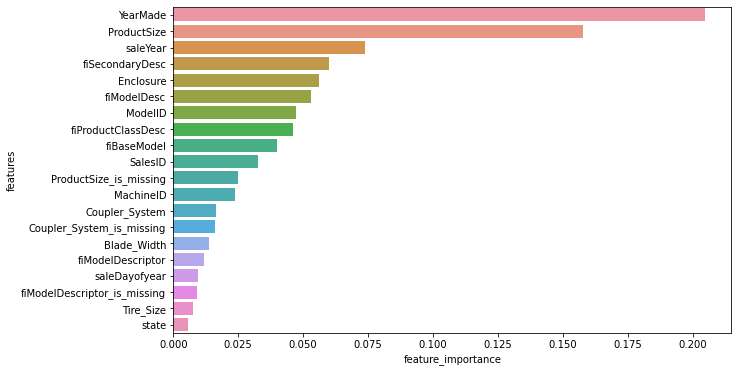

In [195]:
plot_features(X_train.columns, fast_model.feature_importances_)

In [196]:
sum(fast_model.feature_importances_)

0.9999999999999996

In [197]:
df.ProductSize.isna().sum()

223014

In [198]:
df.ProductSize.value_counts()

Medium            66372
Large / Medium    52992
Small             27781
Mini              26718
Large             21840
Compact            6438
Name: ProductSize, dtype: int64

In [199]:
df.Turbocharged.value_counts()

None or Unspecified    79157
Yes                     4047
Name: Turbocharged, dtype: int64

In [200]:
df.Thumb.value_counts()

None or Unspecified    87595
Manual                  9997
Hydraulic               8135
Name: Thumb, dtype: int64